In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime
mpl.use('TkAgg')

In [2]:
#sheet_name="Desorption"
sheet_name="Adsorption"
list_name = "Carbon-loc-isoth-N2.xlsx"
#list_name = "Silica-loc-isoth1.xlsx"
dataframe_sorb = pd.read_excel(list_name, header=None, sheet_name=sheet_name)
P_START = 21  # индекс минимального давления
p_array = np.array(dataframe_sorb[0][P_START:])  # сетка давлений
a_array = np.array(dataframe_sorb.iloc[0][1:])  # сетка размеров пор

array_of_isotherms = np.empty((len(a_array), len(p_array)))  # массив изотерм с i-м размером пор
for i in range(len(a_array)):  # заполняем массив изотерм из таблицы pandas
    array_of_isotherms[i] = dataframe_sorb[i+1][P_START:]
    
j = 100
fig, ax=plt.subplots()  # строим график j-й изотермы из исходного набора
ax.plot(p_array, array_of_isotherms[j], marker=".", label=f"kernel isotherm №{j}, pore size = {a_array[j]} nm")
ax.set_ylabel("sorption")
ax.set_xlabel("pressure")
legend = ax.legend(loc='upper right')
plt.show()    

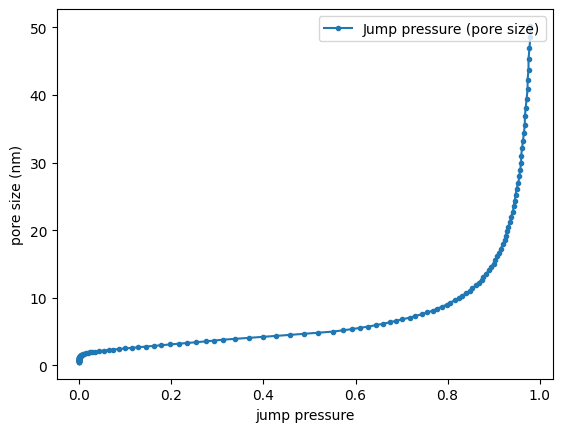

In [3]:
#  обработка изотерм со скачком
pore_size_jump_pressure = pd.DataFrame(columns=['pore_size', 'pressure_of_jump'])  # таблица размер пор - давление при котором происходит скачок в изотерме с данным размером пор
for i, sorption_a in enumerate(array_of_isotherms):
    sorption_delta_array = sorption_a[1:] - sorption_a[:-1]
    jump_i = np.argmax(sorption_delta_array)  # индекс скачка 
    jump_pressure = p_array[jump_i]  #  давление скачка
    pore_size_jump_pressure.loc[len(pore_size_jump_pressure.index)] = [a_array[i], jump_pressure]

fig, ax=plt.subplots()
ax.plot(pore_size_jump_pressure["pressure_of_jump"], pore_size_jump_pressure["pore_size"], marker=".", label="Jump pressure (pore size)")
ax.set_ylabel("pore size (nm)")
ax.set_xlabel("jump pressure")
legend = ax.legend(loc='upper right')
plt.show()

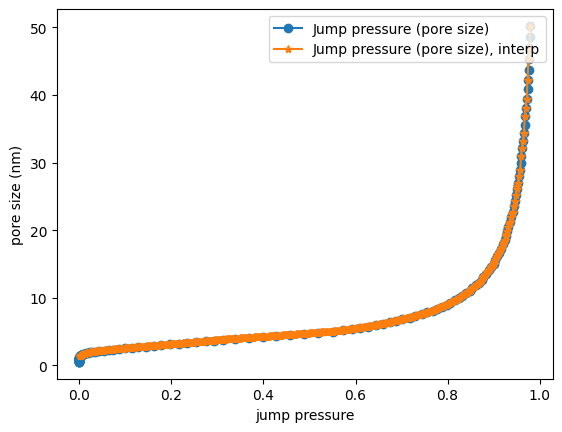

In [4]:
# получаем размеры пор в которых происходит скачок интерполяцией для кажой точки из сетки давлений
new_a_array_raw = np.interp(p_array,  pore_size_jump_pressure["pressure_of_jump"].to_numpy(), pore_size_jump_pressure["pore_size"].to_numpy())
#new_a_array = new_a_array_raw[j_no_step:jump_i+1]  # обрезаем массив пор так как для последних и первых давлений не было изотерм со скачками

j_first_step = 40
j_last_step = np.where(p_array == pore_size_jump_pressure.iloc[-1]["pressure_of_jump"])[0][0] + 1 #  индекс давления последнего скачка


fig, ax=plt.subplots()
ax.plot(pore_size_jump_pressure["pressure_of_jump"], pore_size_jump_pressure["pore_size"], marker="o", label="Jump pressure (pore size)")
ax.plot(p_array[j_first_step:j_last_step], new_a_array_raw[j_first_step:j_last_step], marker="*", label="Jump pressure (pore size), interp")
ax.set_ylabel("pore size (nm)")
ax.set_xlabel("jump pressure")
legend = ax.legend(loc='upper right')
plt.show()
new_a_array = new_a_array_raw[j_first_step:j_last_step]

In [5]:
def get_k_b(x1, y1, x2, y2):
    k = (y1 - y2) / (x1 - x2)
    b = y1 - k*x1
    return k, b

A_START = j_first_step
step_array_train = pore_size_jump_pressure["pressure_of_jump"].to_numpy()
def generate_kernel_isotherm(step_i):
    curent_a_size = new_a_array[step_i]
    new_isotherm = np.zeros(shape=p_array.shape)
    j1, j2  = sorted((np.abs(a_array - curent_a_size)).argsort()[:2])  # находим индексы ближайших к текущему размеров пор
    
    if curent_a_size == a_array[j1]:
        return array_of_isotherms[j1]
    if curent_a_size == a_array[j2]:
        return array_of_isotherms[j2]
    
    i = 0
    while p_array[i] <= pore_size_jump_pressure["pressure_of_jump"][j1]:
        new_isotherm[i] = np.interp(curent_a_size, xp=(a_array[j1], a_array[j2]), fp=(array_of_isotherms[j1][i], array_of_isotherms[j2][i]))
        i += 1
    tmp = i
    
    i = len(p_array) - 1
    while p_array[i] > pore_size_jump_pressure["pressure_of_jump"][j2]:
        new_isotherm[i] = np.interp(curent_a_size, xp=(a_array[j1], a_array[j2]), fp=(array_of_isotherms[j1][i], array_of_isotherms[j2][i]))
        i -= 1
    
    while p_array[i] >= p_array[step_i+A_START]:
        k, b = get_k_b(p_array[i+2], new_isotherm[i+2],  p_array[i+1],  new_isotherm[i+1])
        new_isotherm[i] =  p_array[i] * k + b
        i -= 1
    
    i = tmp
    while p_array[i] <= p_array[step_i+A_START]:
        k, b = get_k_b(p_array[i-2], new_isotherm[i-2],  p_array[i-1],  new_isotherm[i-1])
        new_isotherm[i] =  p_array[i] * k + b
        i += 1
    
    return new_isotherm
    
    
result = []
for step_i in range(len(new_a_array)):
    result.append(generate_kernel_isotherm(step_i))

new isotherm pore size = 1.3303438273813495 nm
base isotherm 27 pore size = 1.31008994579315 nm
base isotherm 28 pore size = 1.35593998432159 nm


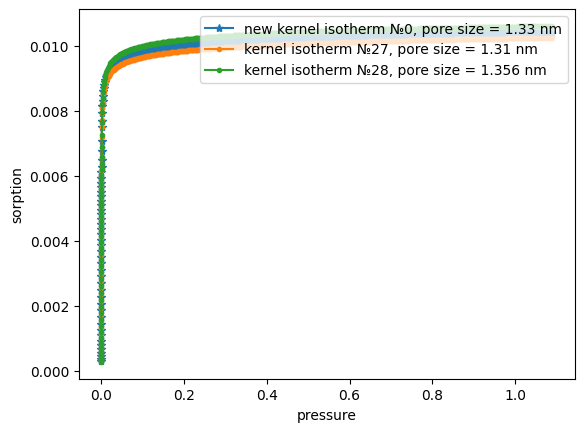

In [6]:
#  строим графики и изучаем новую j-ю изотерму и корневые, по котором ее сгенерировали
fig, ax=plt.subplots()
j = 0
j1, j2 = sorted((np.abs(a_array - new_a_array[j])).argsort()[:2])  # находим индексы ближайших к текущему размеров пор
#print(pore_size_jump_pressure)

# print(f"new isotherm jump pressure {p_array[j+A_START]}")
# print(f"base isotherm {j1} jump pressure {pore_size_jump_pressure['pressure_of_jump'][j1]}")
# print(f"base isotherm {j2} jump pressure {pore_size_jump_pressure['pressure_of_jump'][j2]}")

print(f"new isotherm pore size = {new_a_array[j]} nm")
print(f"base isotherm {j1} pore size = {a_array[j1]} nm")
print(f"base isotherm {j2} pore size = {a_array[j2]} nm")

ax.plot(p_array, result[j], marker = "*", label=f"new kernel isotherm №{j}, pore size = {round(new_a_array[j], 3)} nm")
ax.plot(p_array,  array_of_isotherms[j1], marker = ".", label=f"kernel isotherm №{j1}, pore size = {round(a_array[j1], 3)} nm")
ax.plot(p_array, array_of_isotherms[j2], marker = ".", label=f"kernel isotherm №{j2}, pore size = {round(a_array[j2], 3)} nm")

legend = ax.legend(loc='upper right')
ax.set_ylabel("sorption")
ax.set_xlabel("pressure")
plt.show()

In [7]:
# анимация всех новых изотерм
def create_animation():
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5, True)
    line1, = ax.plot(p_array, result[0], marker = ".", label="")
    j1, j2 = sorted((np.abs(a_array - new_a_array[0])).argsort()[:2])
    line2, = ax.plot(p_array, array_of_isotherms[j1], marker = ".", label="")
    line3, = ax.plot(p_array, array_of_isotherms[j2], marker = ".", label="")

    texts = [ax.text(0.70, 0.1-i*0.05,  '', transform=ax.transAxes) for i in range(3)]

    ax.set_xlim(0, 1)
    ax.set_ylim(0, array_of_isotherms[j2][-1])
    ax.set_ylabel("sorption")
    ax.set_xlabel("pressure")
    def update(frame):
        line1.set_ydata(result[frame])
        j1, j2 = sorted((np.abs(a_array - new_a_array[frame])).argsort()[:2])
        line2.set_ydata(array_of_isotherms[j1])
        line3.set_ydata(array_of_isotherms[j2])
        ax.set_ylim(0, array_of_isotherms[j2][-1]*1.1)
        texts[0].set_text(f"new kernel isotherm №{frame}, pore size = {round(new_a_array[frame], 2)} nm")
        texts[1].set_text(f"kernel isotherm №{j1}, pore size = {round(a_array[j1], 2)} nm")
        texts[2].set_text(f"kernel isotherm №{j2}, pore size = {round(a_array[j2], 2)} nm")
        return (line1, line2, line3)

    ani = animation.FuncAnimation(fig=fig, func=update, frames=len(result), interval=100)
    writervideo = animation.FFMpegWriter(fps=len(result)/100)
    ani.save('test.mp4', writer=writervideo, dpi = 200)
    plt.show()
    
#create_animation()

In [8]:
new_kernel_set = np.concatenate((array_of_isotherms[:j_first_step], np.array(result)), axis=0)
new_a_size_set = np.concatenate((a_array[:j_first_step], new_a_array), axis=0)

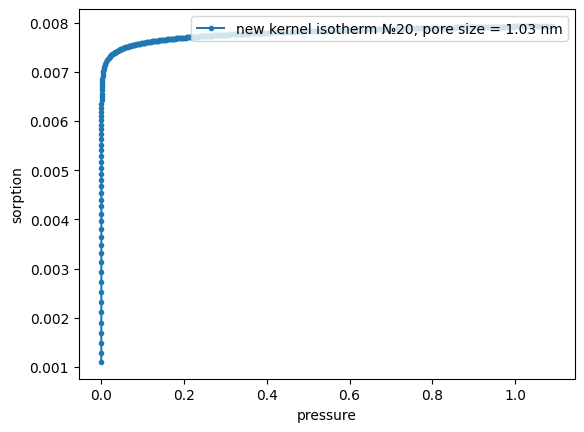

In [9]:
fig, ax=plt.subplots()
j = 20
ax.plot(p_array, new_kernel_set[j], marker = ".", label=f"new kernel isotherm №{j}, pore size = {round(new_a_size_set[j], 3)} nm")

# j = 1
# ax.plot(p_array, new_kernel_set[j], marker = ".", label=f"new kernel isotherm №{j}, pore size = {round(new_a_size_set[j], 3)} nm")


legend = ax.legend(loc='upper right')
ax.set_ylabel("sorption")
ax.set_xlabel("pressure")
plt.show()

In [10]:
# сохраняем изотермы и размеры пор в формате np
#now = datetime.now().strftime('%Y-%m-%d_T_%H-%M-%S')
with open(f'data/kernel_generated/Kernel_{list_name}_{sheet_name}.npy', 'wb') as f:
    np.save(f, new_kernel_set)

with open(f'data/kernel_generated/Size_{list_name}_{sheet_name}.npy', 'wb') as f:
    np.save(f, new_a_size_set)